# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.03402719 -0.17293937  0.03170829  0.31115956] 0 1.0 False {}
state, action, reward, done, info: [0.0305684  0.02171683 0.03793148 0.02864272] 1 1.0 False {}
state, action, reward, done, info: [ 0.03100273  0.21627486  0.03850434 -0.25183523] 1 1.0 False {}
state, action, reward, done, info: [0.03532823 0.02062484 0.03346763 0.05273975] 0 1.0 False {}
state, action, reward, done, info: [ 0.03574073  0.21525133  0.03452243 -0.22919884] 1 1.0 False {}
state, action, reward, done, info: [ 0.04004576  0.40986337  0.02993845 -0.5107954 ] 1 1.0 False {}
state, action, reward, done, info: [ 0.04824302  0.60455107  0.01972254 -0.7938955 ] 1 1.0 False {}
state, action, reward, done, info: [ 0.06033404  0.79939683  0.00384463 -1.08030924] 1 1.0 False {}
state, action, reward, done, info: [ 0.07632198  0.99446781 -0.01776155 -1.37178323] 1 1.0 False {}
state, action, reward, done, info: [ 0.09621134  1.18980732 -0.04519722 -1.6699679 ] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [7]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
def model_loss(states, actions, targetQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    
    # Calculating action logits: Used to calculate Qs and targetQs
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # # Calculating targetQs using NEW memory using rewards
    # rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
    # Qs = np.max(rewarded_actions_logits, axis=1)
    
    # # Calculating Qs using NEW memory using actions
    # Onehot vectorizing the actions logits
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [9]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:1


In [13]:
# Training parameters
train_episodes = 4000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [14]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
state, reward, action

(array([ 0.0228471 ,  0.22409558, -0.026794  , -0.23747894]), 1.0, 0)

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])

            # Calculating targetQs/nextQs using NEW memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)            
            rewarded_actions_logits = np.multiply(actions_logits, rewards.reshape([-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)

            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.states: states, 
                         model.actions: actions, 
                         model.targetQs: Qs} # labelQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.4f}'.format(np.mean(loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 21.0 Average loss: 0.0290 Explore P: 0.9978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10.0 Average loss: 0.0806 Explore P: 0.9967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 11.0 Average loss: 0.2319 Explore P: 0.9956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 16.0 Average loss: 0.6733 Explore P: 0.9939
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 36 Total reward: 31.0 Average loss: 1298.4944 Explore P: 0.9202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 15.0 Average loss: 1603.7013 Explore P: 0.9188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 28.0 Average loss: 1792.8174 Explore P: 0.9162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 40.0 Average loss: 3133.0483 Explore P: 0.9124
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 30.0 Average loss: 62276616.0000 Explore P: 0.8254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 14.0 Average loss: 98547592.0000 Explore P: 0.8242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 32.0 Average loss: 161437728.0000 Explore P: 0.8215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 9.0 Average loss: 248945312.0000 Explore P: 0.8207
-------------------------------------------------------------------------------
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 106 Total reward: 89.0 Average loss: 3439673475072.0000 Explore P: 0.6941
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 57.0 Average loss: 3736463212544.0000 Explore P: 0.6901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 40.0 Average loss: 3398073319424.0000 Explore P: 0.6874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 133.0 Average loss: 3096489754624.0000 Explore P: 0.6783
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 140 Total reward: 83.0 Average loss: 76155096924160.0000 Explore P: 0.5399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 63.0 Average loss: 74536540176384.0000 Explore P: 0.5365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 144.0 Average loss: 67806427086848.0000 Explore P: 0.5289
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 82.0 Average loss: 58130268422144.0000 Explore P: 0.5246
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 174 Total reward: 199.0 Average loss: 158549506260992.0000 Explore P: 0.3408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 175 Total reward: 199.0 Average loss: 168311497162752.0000 Explore P: 0.3343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 183.0 Average loss: 221487587917824.0000 Explore P: 0.3284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 147.0 Average loss: 204885509275648.0000 Explore P: 0.3237
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Average loss: 94786103017472.0000 Explore P: 0.2264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 196.0 Average loss: 60359104790528.0000 Explore P: 0.2222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Average loss: 46002744590336.0000 Explore P: 0.2180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 199.0 Average loss: 43813741527040.0000 Explore P: 0.2139
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 242 Total reward: 199.0 Average loss: 1789040844079104.0000 Explore P: 0.1203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 199.0 Average loss: 1319415161290752.0000 Explore P: 0.1182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 199.0 Average loss: 724741371461632.0000 Explore P: 0.1160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 199.0 Average loss: 613487894069248.0000 Explore P: 0.1139
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 276 Total reward: 199.0 Average loss: 25209348292608.0000 Explore P: 0.0659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Average loss: 34187075649536.0000 Explore P: 0.0648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average loss: 36409863831552.0000 Explore P: 0.0637
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average loss: 41975474552832.0000 Explore P: 0.0626
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 310 Total reward: 199.0 Average loss: 99346494259200.0000 Explore P: 0.0383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 311 Total reward: 199.0 Average loss: 76258889170944.0000 Explore P: 0.0378
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Average loss: 48613648498688.0000 Explore P: 0.0372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 199.0 Average loss: 60649438707712.0000 Explore P: 0.0367
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 344 Total reward: 199.0 Average loss: 8861448667136.0000 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 Average loss: 43097920634880.0000 Explore P: 0.0241
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Average loss: 38030068940800.0000 Explore P: 0.0238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Average loss: 22827944116224.0000 Explore P: 0.0235
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 378 Total reward: 199.0 Average loss: 24651675729920.0000 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 379 Total reward: 199.0 Average loss: 24283787034624.0000 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 380 Total reward: 199.0 Average loss: 22638984429568.0000 Explore P: 0.0170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 199.0 Average loss: 20476994781184.0000 Explore P: 0.0168
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 412 Total reward: 199.0 Average loss: 38647306911744.0000 Explore P: 0.0137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 413 Total reward: 199.0 Average loss: 36238228717568.0000 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 199.0 Average loss: 34049357774848.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 199.0 Average loss: 39436804947968.0000 Explore P: 0.0135
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 446 Total reward: 199.0 Average loss: 35959869538304.0000 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 447 Total reward: 199.0 Average loss: 23011958718464.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 199.0 Average loss: 30865665032192.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 199.0 Average loss: 41920000688128.0000 Explore P: 0.0118
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 480 Total reward: 199.0 Average loss: 34477948534784.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 481 Total reward: 199.0 Average loss: 33238194061312.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 482 Total reward: 199.0 Average loss: 39494774423552.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199.0 Average loss: 33967484960768.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 514 Total reward: 199.0 Average loss: 23116451414016.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 515 Total reward: 199.0 Average loss: 36701644783616.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 516 Total reward: 199.0 Average loss: 42060820250624.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 517 Total reward: 199.0 Average loss: 27214053638144.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 548 Total reward: 199.0 Average loss: 35188897742848.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 549 Total reward: 199.0 Average loss: 36235523391488.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 550 Total reward: 199.0 Average loss: 36031252398080.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 551 Total reward: 199.0 Average loss: 46205660823552.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 582 Total reward: 199.0 Average loss: 40868648058880.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 199.0 Average loss: 42385304190976.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 199.0 Average loss: 35860011548672.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 199.0 Average loss: 26585396674560.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 616 Total reward: 199.0 Average loss: 26582206906368.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 199.0 Average loss: 32956364095488.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 199.0 Average loss: 31182628585472.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 619 Total reward: 199.0 Average loss: 30579087114240.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 650 Total reward: 199.0 Average loss: 50769000660992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 199.0 Average loss: 45653161934848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 199.0 Average loss: 28734646124544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 199.0 Average loss: 25058005221376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 684 Total reward: 199.0 Average loss: 24116119732224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 685 Total reward: 199.0 Average loss: 31420160409600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 199.0 Average loss: 31363891724288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 199.0 Average loss: 26185689989120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 718 Total reward: 199.0 Average loss: 27662405861376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 719 Total reward: 199.0 Average loss: 31493824970752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 199.0 Average loss: 32516364828672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 199.0 Average loss: 36636075229184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 752 Total reward: 199.0 Average loss: 40089933578240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 199.0 Average loss: 34157317062656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 754 Total reward: 199.0 Average loss: 31479845355520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 755 Total reward: 199.0 Average loss: 23273989472256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 786 Total reward: 199.0 Average loss: 27285329543168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 199.0 Average loss: 24193135542272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 199.0 Average loss: 23707009417216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 199.0 Average loss: 29694443388928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 820 Total reward: 199.0 Average loss: 28746088185856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 199.0 Average loss: 38519259004928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 199.0 Average loss: 43416486412288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 199.0 Average loss: 37376428605440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 854 Total reward: 199.0 Average loss: 22042627801088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 199.0 Average loss: 29003868012544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 199.0 Average loss: 30140348235776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 199.0 Average loss: 28124328755200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 888 Total reward: 199.0 Average loss: 31044686315520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 889 Total reward: 199.0 Average loss: 40947677134848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 199.0 Average loss: 42528581615616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 199.0 Average loss: 43131999354880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 922 Total reward: 199.0 Average loss: 24581553258496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 923 Total reward: 199.0 Average loss: 24484650156032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 199.0 Average loss: 26531065757696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 199.0 Average loss: 24029970825216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 956 Total reward: 199.0 Average loss: 24715980701696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 957 Total reward: 199.0 Average loss: 26994999820288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 958 Total reward: 199.0 Average loss: 28580828413952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 959 Total reward: 199.0 Average loss: 36480592379904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 990 Total reward: 199.0 Average loss: 19382537289728.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 991 Total reward: 199.0 Average loss: 22477650526208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 199.0 Average loss: 23534971650048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 199.0 Average loss: 25150850334720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 1024 Total reward: 199.0 Average loss: 23635559448576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 199.0 Average loss: 22891187929088.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 199.0 Average loss: 24628676263936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1027 Total reward: 199.0 Average loss: 23105307148288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1058 Total reward: 199.0 Average loss: 17475077931008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1059 Total reward: 199.0 Average loss: 17206221996032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1060 Total reward: 199.0 Average loss: 22272106561536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1061 Total reward: 199.0 Average loss: 24422773686272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1092 Total reward: 199.0 Average loss: 23497019490304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1093 Total reward: 199.0 Average loss: 21431519805440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1094 Total reward: 199.0 Average loss: 16760857165824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1095 Total reward: 199.0 Average loss: 22631889764352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1126 Total reward: 199.0 Average loss: 23188876558336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1127 Total reward: 199.0 Average loss: 28891766849536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 199.0 Average loss: 31356694298624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 199.0 Average loss: 29589736783872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1160 Total reward: 199.0 Average loss: 28117030666240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1161 Total reward: 199.0 Average loss: 25313274757120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 199.0 Average loss: 24093854269440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1163 Total reward: 199.0 Average loss: 31193749782528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1194 Total reward: 199.0 Average loss: 28035151560704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1195 Total reward: 199.0 Average loss: 31372466978816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1196 Total reward: 199.0 Average loss: 23843053764608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1197 Total reward: 199.0 Average loss: 20246121414656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1228 Total reward: 199.0 Average loss: 40874356506624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 199.0 Average loss: 28513520320512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 199.0 Average loss: 30706094833664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 199.0 Average loss: 35829380546560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1262 Total reward: 199.0 Average loss: 36857144410112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1263 Total reward: 199.0 Average loss: 33040348741632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1264 Total reward: 199.0 Average loss: 27013784010752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 199.0 Average loss: 19945956048896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1296 Total reward: 199.0 Average loss: 35542523707392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 199.0 Average loss: 36635102150656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 199.0 Average loss: 39650693480448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1299 Total reward: 199.0 Average loss: 34840380440576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1330 Total reward: 199.0 Average loss: 28573047980032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1331 Total reward: 199.0 Average loss: 32899476750336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1332 Total reward: 199.0 Average loss: 35076718985216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1333 Total reward: 199.0 Average loss: 33226796040192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1364 Total reward: 199.0 Average loss: 30624159105024.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1365 Total reward: 199.0 Average loss: 29164962840576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1366 Total reward: 199.0 Average loss: 30749533143040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1367 Total reward: 199.0 Average loss: 32677344313344.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1398 Total reward: 199.0 Average loss: 30761426092032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1399 Total reward: 199.0 Average loss: 21891741908992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1400 Total reward: 199.0 Average loss: 28340981334016.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1401 Total reward: 199.0 Average loss: 34896185655296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1432 Total reward: 199.0 Average loss: 26873465667584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1433 Total reward: 199.0 Average loss: 28580094410752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 199.0 Average loss: 29128055062528.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 199.0 Average loss: 33012947353600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1466 Total reward: 199.0 Average loss: 31251104792576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1467 Total reward: 199.0 Average loss: 36946885738496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1468 Total reward: 199.0 Average loss: 29457586847744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1469 Total reward: 199.0 Average loss: 25814720577536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1500 Total reward: 199.0 Average loss: 43036549578752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1501 Total reward: 199.0 Average loss: 35965737369600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1502 Total reward: 199.0 Average loss: 29415721402368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1503 Total reward: 199.0 Average loss: 27018517282816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1534 Total reward: 199.0 Average loss: 38819709583360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1535 Total reward: 199.0 Average loss: 38219953471488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1536 Total reward: 199.0 Average loss: 27589888442368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1537 Total reward: 199.0 Average loss: 26480719429632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1568 Total reward: 199.0 Average loss: 28739224207360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 199.0 Average loss: 29714993381376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 199.0 Average loss: 27370310336512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1571 Total reward: 199.0 Average loss: 32814837792768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1602 Total reward: 199.0 Average loss: 49639826915328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1603 Total reward: 199.0 Average loss: 41642224517120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1604 Total reward: 199.0 Average loss: 27437700218880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1605 Total reward: 199.0 Average loss: 21988783423488.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1636 Total reward: 199.0 Average loss: 34090638114816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1637 Total reward: 199.0 Average loss: 32917541617664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 199.0 Average loss: 35685255872512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 199.0 Average loss: 36741457117184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1670 Total reward: 199.0 Average loss: 24066436104192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 199.0 Average loss: 21889942552576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 199.0 Average loss: 17077125513216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1673 Total reward: 199.0 Average loss: 14863555362816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1704 Total reward: 199.0 Average loss: 29870906146816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 199.0 Average loss: 43553321385984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1706 Total reward: 199.0 Average loss: 54648954159104.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 199.0 Average loss: 45775065186304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1738 Total reward: 199.0 Average loss: 37764322033664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1739 Total reward: 199.0 Average loss: 23777731674112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1740 Total reward: 199.0 Average loss: 20495233712128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1741 Total reward: 199.0 Average loss: 33364239187968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1772 Total reward: 199.0 Average loss: 33959259930624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1773 Total reward: 199.0 Average loss: 25548629737472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1774 Total reward: 199.0 Average loss: 24640239960064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1775 Total reward: 199.0 Average loss: 32193004961792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1806 Total reward: 199.0 Average loss: 31126550740992.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1807 Total reward: 199.0 Average loss: 39576248778752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1808 Total reward: 199.0 Average loss: 37593060212736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1809 Total reward: 199.0 Average loss: 19009619623936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1840 Total reward: 199.0 Average loss: 28274027659264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1841 Total reward: 199.0 Average loss: 16631535239168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 199.0 Average loss: 17015341318144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 199.0 Average loss: 18815505137664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1874 Total reward: 199.0 Average loss: 19521127579648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1875 Total reward: 199.0 Average loss: 16283923906560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1876 Total reward: 199.0 Average loss: 20210383847424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 199.0 Average loss: 22780806430720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1908 Total reward: 199.0 Average loss: 25068065259520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 199.0 Average loss: 39566664794112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1910 Total reward: 199.0 Average loss: 55375969648640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1911 Total reward: 199.0 Average loss: 58974271438848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1942 Total reward: 199.0 Average loss: 40423938588672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1943 Total reward: 199.0 Average loss: 34414654390272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1944 Total reward: 199.0 Average loss: 27696048373760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1945 Total reward: 199.0 Average loss: 22900723679232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 1976 Total reward: 199.0 Average loss: 41628932767744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1977 Total reward: 199.0 Average loss: 38896616341504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1978 Total reward: 199.0 Average loss: 34415581331456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1979 Total reward: 199.0 Average loss: 37594129760256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2010 Total reward: 199.0 Average loss: 19357115613184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2011 Total reward: 199.0 Average loss: 30302982373376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2012 Total reward: 199.0 Average loss: 34579473760256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2013 Total reward: 199.0 Average loss: 27056383459328.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2044 Total reward: 199.0 Average loss: 24383376588800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2045 Total reward: 199.0 Average loss: 27645861429248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2046 Total reward: 199.0 Average loss: 26309853970432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2047 Total reward: 199.0 Average loss: 23102887034880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2078 Total reward: 199.0 Average loss: 18132074758144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2079 Total reward: 199.0 Average loss: 17210940588032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2080 Total reward: 199.0 Average loss: 14305946763264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2081 Total reward: 199.0 Average loss: 29637411340288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2112 Total reward: 199.0 Average loss: 34231625449472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2113 Total reward: 199.0 Average loss: 28237488979968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2114 Total reward: 199.0 Average loss: 14912575242240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2115 Total reward: 199.0 Average loss: 16767695978496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2146 Total reward: 199.0 Average loss: 26425146998784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2147 Total reward: 199.0 Average loss: 26606500315136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2148 Total reward: 199.0 Average loss: 26333818126336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2149 Total reward: 199.0 Average loss: 19946729897984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2180 Total reward: 199.0 Average loss: 29683754205184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2181 Total reward: 199.0 Average loss: 42246179127296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2182 Total reward: 199.0 Average loss: 45742337032192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2183 Total reward: 199.0 Average loss: 33653960736768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2214 Total reward: 199.0 Average loss: 25557769125888.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2215 Total reward: 199.0 Average loss: 25391278325760.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2216 Total reward: 199.0 Average loss: 30171769864192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2217 Total reward: 199.0 Average loss: 25894303301632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2248 Total reward: 199.0 Average loss: 20730190233600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2249 Total reward: 199.0 Average loss: 23109065244672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2250 Total reward: 199.0 Average loss: 20696818253824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2251 Total reward: 199.0 Average loss: 16158767972352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2282 Total reward: 199.0 Average loss: 23539719602176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2283 Total reward: 199.0 Average loss: 32714833002496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2284 Total reward: 199.0 Average loss: 37131242176512.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2285 Total reward: 199.0 Average loss: 29085464002560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2316 Total reward: 199.0 Average loss: 17491674791936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2317 Total reward: 199.0 Average loss: 23665311744000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2318 Total reward: 199.0 Average loss: 29356338446336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2319 Total reward: 199.0 Average loss: 24551203274752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2350 Total reward: 199.0 Average loss: 18406698909696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2351 Total reward: 199.0 Average loss: 22278511263744.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2352 Total reward: 199.0 Average loss: 24748935348224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2353 Total reward: 199.0 Average loss: 30845714825216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2384 Total reward: 199.0 Average loss: 36894855397376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2385 Total reward: 199.0 Average loss: 31570587025408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2386 Total reward: 199.0 Average loss: 24681279127552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2387 Total reward: 199.0 Average loss: 18589451026432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2418 Total reward: 199.0 Average loss: 44599057842176.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2419 Total reward: 199.0 Average loss: 39267925491712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 199.0 Average loss: 33662678597632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2421 Total reward: 199.0 Average loss: 20807398981632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2452 Total reward: 199.0 Average loss: 41141063909376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2453 Total reward: 199.0 Average loss: 40005330272256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2454 Total reward: 199.0 Average loss: 34561503264768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2455 Total reward: 199.0 Average loss: 30514710839296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2486 Total reward: 199.0 Average loss: 28268440846336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2487 Total reward: 199.0 Average loss: 28974063288320.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2488 Total reward: 199.0 Average loss: 31999819513856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2489 Total reward: 199.0 Average loss: 39669324578816.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2520 Total reward: 199.0 Average loss: 35672500994048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2521 Total reward: 199.0 Average loss: 49906941165568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2522 Total reward: 199.0 Average loss: 52230828851200.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2523 Total reward: 199.0 Average loss: 46024525611008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2554 Total reward: 199.0 Average loss: 38953084256256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2555 Total reward: 199.0 Average loss: 50734703837184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2556 Total reward: 199.0 Average loss: 40457841147904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2557 Total reward: 199.0 Average loss: 25047422992384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2588 Total reward: 199.0 Average loss: 29115105148928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2589 Total reward: 199.0 Average loss: 34420056653824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2590 Total reward: 199.0 Average loss: 32720749068288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2591 Total reward: 199.0 Average loss: 30300172189696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2622 Total reward: 199.0 Average loss: 27060080738304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2623 Total reward: 199.0 Average loss: 28029304700928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2624 Total reward: 199.0 Average loss: 33378262843392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 199.0 Average loss: 36486355353600.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2656 Total reward: 199.0 Average loss: 17262587150336.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2657 Total reward: 199.0 Average loss: 16558121287680.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2658 Total reward: 199.0 Average loss: 19137212448768.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2659 Total reward: 199.0 Average loss: 22456410570752.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2690 Total reward: 199.0 Average loss: 23114595434496.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2691 Total reward: 199.0 Average loss: 22648595677184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2692 Total reward: 199.0 Average loss: 22379294097408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2693 Total reward: 199.0 Average loss: 19116381437952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2724 Total reward: 199.0 Average loss: 26243680436224.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2725 Total reward: 199.0 Average loss: 19310661599232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2726 Total reward: 199.0 Average loss: 22200042127360.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2727 Total reward: 199.0 Average loss: 22380835504128.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2758 Total reward: 199.0 Average loss: 32967401406464.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2759 Total reward: 199.0 Average loss: 29578777067520.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2760 Total reward: 199.0 Average loss: 22300982247424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2761 Total reward: 199.0 Average loss: 21124779868160.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2792 Total reward: 199.0 Average loss: 16699799633920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2793 Total reward: 199.0 Average loss: 17455079489536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2794 Total reward: 199.0 Average loss: 17144224940032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2795 Total reward: 199.0 Average loss: 25538339012608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2826 Total reward: 199.0 Average loss: 33016927748096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2827 Total reward: 199.0 Average loss: 31456013320192.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2828 Total reward: 199.0 Average loss: 27611233255424.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2829 Total reward: 199.0 Average loss: 25304626102272.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2860 Total reward: 199.0 Average loss: 42684660056064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2861 Total reward: 199.0 Average loss: 39922513739776.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2862 Total reward: 199.0 Average loss: 30105986400256.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2863 Total reward: 199.0 Average loss: 21527045079040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2894 Total reward: 199.0 Average loss: 31708342648832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2895 Total reward: 199.0 Average loss: 24684674416640.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2896 Total reward: 199.0 Average loss: 19604145438720.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2897 Total reward: 199.0 Average loss: 29513048129536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2928 Total reward: 199.0 Average loss: 24172101107712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2929 Total reward: 199.0 Average loss: 18198594322432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 199.0 Average loss: 17612002033664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2931 Total reward: 199.0 Average loss: 18003726958592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2962 Total reward: 199.0 Average loss: 19079886798848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2963 Total reward: 199.0 Average loss: 20344815484928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2964 Total reward: 199.0 Average loss: 21992814149632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2965 Total reward: 199.0 Average loss: 23275031756800.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 2996 Total reward: 199.0 Average loss: 39553335296000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2997 Total reward: 199.0 Average loss: 30592752156672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2998 Total reward: 199.0 Average loss: 34198853255168.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2999 Total reward: 199.0 Average loss: 29394842157056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3030 Total reward: 199.0 Average loss: 48553586065408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3031 Total reward: 199.0 Average loss: 42751211077632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3032 Total reward: 199.0 Average loss: 28019380977664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3033 Total reward: 199.0 Average loss: 23242731421696.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3064 Total reward: 199.0 Average loss: 29177350717440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3065 Total reward: 199.0 Average loss: 39842033434624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3066 Total reward: 199.0 Average loss: 39021082312704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3067 Total reward: 199.0 Average loss: 32938110484480.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3098 Total reward: 199.0 Average loss: 24356335910912.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3099 Total reward: 199.0 Average loss: 25197117702144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3100 Total reward: 199.0 Average loss: 23103935610880.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3101 Total reward: 199.0 Average loss: 23961165365248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3132 Total reward: 199.0 Average loss: 22843165245440.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3133 Total reward: 199.0 Average loss: 14736992239616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3134 Total reward: 199.0 Average loss: 19782510313472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3135 Total reward: 199.0 Average loss: 27780299358208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3166 Total reward: 199.0 Average loss: 22392967528448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3167 Total reward: 199.0 Average loss: 33046159949824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3168 Total reward: 199.0 Average loss: 32985355124736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3169 Total reward: 199.0 Average loss: 29192727035904.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3200 Total reward: 199.0 Average loss: 29309211246592.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3201 Total reward: 199.0 Average loss: 30227711393792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3202 Total reward: 199.0 Average loss: 28584387280896.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3203 Total reward: 199.0 Average loss: 27706745946112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3234 Total reward: 199.0 Average loss: 24312685789184.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3235 Total reward: 199.0 Average loss: 21868612419584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3236 Total reward: 199.0 Average loss: 18471398146048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3237 Total reward: 199.0 Average loss: 15792756228096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3268 Total reward: 199.0 Average loss: 22700309348352.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3269 Total reward: 199.0 Average loss: 24204026052608.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3270 Total reward: 199.0 Average loss: 25870852947968.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3271 Total reward: 199.0 Average loss: 32392595111936.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3302 Total reward: 199.0 Average loss: 16170728030208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3303 Total reward: 199.0 Average loss: 13255053410304.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3304 Total reward: 199.0 Average loss: 18979995254784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3305 Total reward: 199.0 Average loss: 21046291857408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3336 Total reward: 199.0 Average loss: 16105638723584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3337 Total reward: 199.0 Average loss: 18138745798656.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3338 Total reward: 199.0 Average loss: 25021615439872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3339 Total reward: 199.0 Average loss: 26203771633664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3370 Total reward: 199.0 Average loss: 29235670417408.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3371 Total reward: 199.0 Average loss: 25224296792064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3372 Total reward: 199.0 Average loss: 24204009275392.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3373 Total reward: 199.0 Average loss: 28889233489920.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3404 Total reward: 199.0 Average loss: 36879357444096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3405 Total reward: 199.0 Average loss: 41972513374208.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3406 Total reward: 199.0 Average loss: 45214253187072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3407 Total reward: 199.0 Average loss: 36793118359552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3438 Total reward: 199.0 Average loss: 25580458213376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3439 Total reward: 199.0 Average loss: 24356780507136.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3440 Total reward: 199.0 Average loss: 20739541434368.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3441 Total reward: 199.0 Average loss: 22612281393152.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3472 Total reward: 199.0 Average loss: 38223707373568.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3473 Total reward: 199.0 Average loss: 37059452469248.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3474 Total reward: 199.0 Average loss: 40430720778240.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3475 Total reward: 199.0 Average loss: 32835782049792.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3506 Total reward: 199.0 Average loss: 38895953641472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3507 Total reward: 199.0 Average loss: 24782701592576.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3508 Total reward: 199.0 Average loss: 17765167529984.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3509 Total reward: 199.0 Average loss: 20241432182784.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3540 Total reward: 199.0 Average loss: 26622931501056.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3541 Total reward: 199.0 Average loss: 25623946854400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3542 Total reward: 199.0 Average loss: 25244035186688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3543 Total reward: 199.0 Average loss: 23653553012736.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3574 Total reward: 199.0 Average loss: 18817166082048.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3575 Total reward: 199.0 Average loss: 19758407745536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3576 Total reward: 199.0 Average loss: 27398034685952.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3577 Total reward: 199.0 Average loss: 35778914680832.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3608 Total reward: 199.0 Average loss: 36859702935552.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3609 Total reward: 199.0 Average loss: 41134306885632.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3610 Total reward: 199.0 Average loss: 27847817166848.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3611 Total reward: 199.0 Average loss: 27922452709376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3642 Total reward: 199.0 Average loss: 23847537475584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3643 Total reward: 199.0 Average loss: 27075979247616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3644 Total reward: 199.0 Average loss: 20622358872064.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3645 Total reward: 199.0 Average loss: 17377525760000.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3676 Total reward: 199.0 Average loss: 30163813269504.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3677 Total reward: 199.0 Average loss: 32675695951872.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3678 Total reward: 199.0 Average loss: 24902958579712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3679 Total reward: 199.0 Average loss: 28552193900544.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3710 Total reward: 199.0 Average loss: 41207589765120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3711 Total reward: 199.0 Average loss: 43179877335040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3712 Total reward: 199.0 Average loss: 39076937859072.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3713 Total reward: 199.0 Average loss: 28790040297472.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3744 Total reward: 199.0 Average loss: 17193588752384.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3745 Total reward: 199.0 Average loss: 14871583260672.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3746 Total reward: 199.0 Average loss: 18799021522944.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3747 Total reward: 199.0 Average loss: 25270425747456.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3778 Total reward: 199.0 Average loss: 28837962317824.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3779 Total reward: 199.0 Average loss: 28270231814144.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3780 Total reward: 199.0 Average loss: 20831077924864.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3781 Total reward: 199.0 Average loss: 21649510367232.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3812 Total reward: 199.0 Average loss: 33961417900032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3813 Total reward: 199.0 Average loss: 27505786355712.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3814 Total reward: 199.0 Average loss: 21298241601536.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3815 Total reward: 199.0 Average loss: 22181476040704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3846 Total reward: 199.0 Average loss: 35508872806400.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3847 Total reward: 199.0 Average loss: 30068803895296.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3848 Total reward: 199.0 Average loss: 25074952306688.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3849 Total reward: 199.0 Average loss: 31123472121856.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3880 Total reward: 199.0 Average loss: 22387846283264.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3881 Total reward: 199.0 Average loss: 18138833879040.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3882 Total reward: 199.0 Average loss: 17393975820288.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3883 Total reward: 199.0 Average loss: 24146268389376.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3914 Total reward: 199.0 Average loss: 23686927089664.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3915 Total reward: 199.0 Average loss: 23535894396928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3916 Total reward: 199.0 Average loss: 23952422338560.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3917 Total reward: 199.0 Average loss: 31017700163584.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3948 Total reward: 199.0 Average loss: 22361036292096.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3949 Total reward: 199.0 Average loss: 21725834117120.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3950 Total reward: 199.0 Average loss: 20558659977216.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3951 Total reward: 199.0 Average loss: 17863964360704.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 3982 Total reward: 199.0 Average loss: 23416964907008.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3983 Total reward: 199.0 Average loss: 26151042940928.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3984 Total reward: 199.0 Average loss: 39198732058624.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3985 Total reward: 199.0 Average loss: 46545290395648.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
----------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

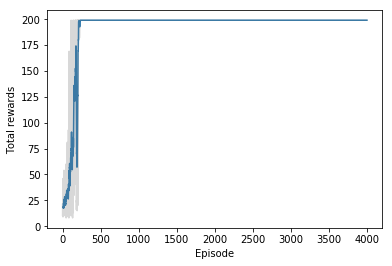

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

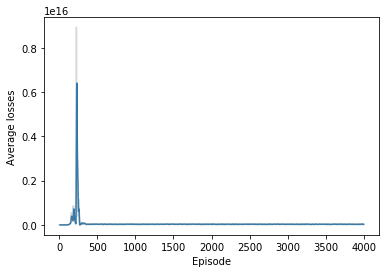

In [20]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [22]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


NoSuchDisplayException: Cannot connect to "None"

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.